<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Lab 02 - Introduction To Data Science @ FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 4.0 - Data modelling
</div>

# Introduction

Predicting how many people will watch YouTube video is tough, but it's getting more important for both creators and companies. While making great content matters most, there are other things we can look at to guess how many views we might get, like how long your video is and what tags we use. This notebook explores these details can help predict how many people will watch our video, which could help us make better content and reach the right audience.

# Import

In [1]:
import ast
import re
from joblib import dump, load

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error

random_state = 1

# Data preparation

In [2]:
df_videos = pd.read_csv('../data/processed/df_videos_processed.csv')

# Feature engineering

This section outlines the feature engineering process undertaken to construct informative features from video durations and tags for the purpose of predicting view counts. The goal of this process is to transform raw data into meaningful features that can be effectively utilized by a predictive model.

We are going to convert these columns to appropriate data types and clean the tags.

In [3]:
def clean_text(text):
  text = text.replace('.', '').replace('#', '').replace('$', '').replace(' ', '')
  text = re.sub(r'\b\d+\.\d+\b', '', text)
  text = text.lower()
  if text == '':
    return np.nan
  return text

In [4]:
df_process = df_videos[df_videos['tags'].notnull()][['view_count', 'duration', 'tags']]
df_process['duration'] = df_process['duration'].apply(pd.to_timedelta).dt.total_seconds()
df_process['tags'] = df_process['tags'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)
df_process['tags'] = df_process['tags'].apply(lambda x: list(set([clean_text(tag) for tag in x])))

How many unique tags are there?

In [5]:
df_process['tags'].explode().nunique()

22770

There are quite a lot of tags, so we will select only some of the repeating tags to improve model performance.

In [6]:
selected_tag = df_process['tags'].explode().value_counts()
threshold = 100
selected_tag = selected_tag[selected_tag > threshold]
len(selected_tag)

94

Save these tags for deployment.

In [7]:
selected_tag.sort_index().reset_index()['index'].to_json('../deploy/materials/tags.json')

Remove tags that are not in the selected tags.

In [8]:
df_process['clean_tags'] = df_process['tags'].apply(lambda x: [tag for tag in x if tag in selected_tag])

In [9]:
df_process = df_process[df_process['clean_tags'].apply(len) > 0]

Remove outliers from `view_count` and `duration` columns.

In [10]:
df_process = df_process[(np.abs(stats.zscore(df_process[['view_count', 'duration']])) < 3).all(axis=1)].reset_index(drop = True)

# Training model

## Setting up

In [11]:
X = df_process[['duration', 'clean_tags']]
y = df_process['view_count']

In [12]:
mlb = MultiLabelBinarizer()
X = X.join(pd.DataFrame(mlb.fit_transform(X.pop('clean_tags')), columns = mlb.classes_))

In [13]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = random_state)

In [14]:
regr = RandomForestRegressor(random_state = random_state)

In [15]:
param_grid = {'n_estimators': [100, 150, 200],
              'criterion': ['squared_error', 'friedman_mse', 'poisson'],
              'max_depth': [None, 10],
              'max_features': [None, 'sqrt']}

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

## Cross validation and hyperparameter tuning

In [17]:
grid_cv = GridSearchCV(estimator = regr, param_grid = param_grid, cv = kfold,
                       scoring = 'neg_mean_absolute_error', n_jobs = 1, verbose = 3)

In [18]:
grid_cv.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END criterion=squared_error, max_depth=None, max_features=None, n_estimators=100;, score=-86042.280 total time=   2.0s
[CV 2/10] END criterion=squared_error, max_depth=None, max_features=None, n_estimators=100;, score=-86100.711 total time=   2.0s
[CV 3/10] END criterion=squared_error, max_depth=None, max_features=None, n_estimators=100;, score=-110945.733 total time=   1.9s
[CV 4/10] END criterion=squared_error, max_depth=None, max_features=None, n_estimators=100;, score=-123057.137 total time=   1.9s
[CV 5/10] END criterion=squared_error, max_depth=None, max_features=None, n_estimators=100;, score=-99910.363 total time=   1.9s
[CV 6/10] END criterion=squared_error, max_depth=None, max_features=None, n_estimators=100;, score=-111843.812 total time=   2.0s
[CV 7/10] END criterion=squared_error, max_depth=None, max_features=None, n_estimators=100;, score=-114630.544 total time=   2.0s
[CV 8/10] END criterion=square

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(random_state=1), n_jobs=1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'poisson'],
                         'max_depth': [None, 10],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_absolute_error', verbose=3)

## Train the best model from GridSearchCV

In [19]:
grid_cv.best_params_

{'criterion': 'poisson',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [20]:
model = grid_cv.best_estimator_

In [21]:
model.fit(X_train, y_train)

RandomForestRegressor(criterion='poisson', max_features='sqrt',
                      n_estimators=200, random_state=1)

# Evaluation

In [22]:
predictions = model.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))

Mean Absolute Error (MAE): 105733.69832869848
Mean Squared Error (MSE): 67879270447.39259
Root Mean Squared Error (MSE): 260536.5050187643


MAE, MSE, and RMSE are error metrics that quantify model predictions' deviations from actual values. High scores indicate significant prediction errors.

Possible causes:
- Overfitting: Model captures noise in training data, failing to generalise to new examples.
- Underfitting: Model lacks complexity to capture underlying patterns in data.
- Data quality issues: Undetected noise, outliers, biased in data distort model learning.

# Prediction

The results of `y_test` compared to `y_pred`.

In [23]:
df_pred = pd.concat([y_test.reset_index(drop = True), pd.Series(model.predict(X_test))], axis = 1)
df_pred.columns = ['y_test', 'y_pred']
df_pred

,y_test,y_pred
0,1194,2523.04000
1,40118,57998.13000
2,73335,61073.33000
3,18212,215260.98000
4,922,2419.91000
...,...,...
817,1204,1556.95375
818,14869,72639.25500
819,8965,6935.94500
820,124556,251259.16000


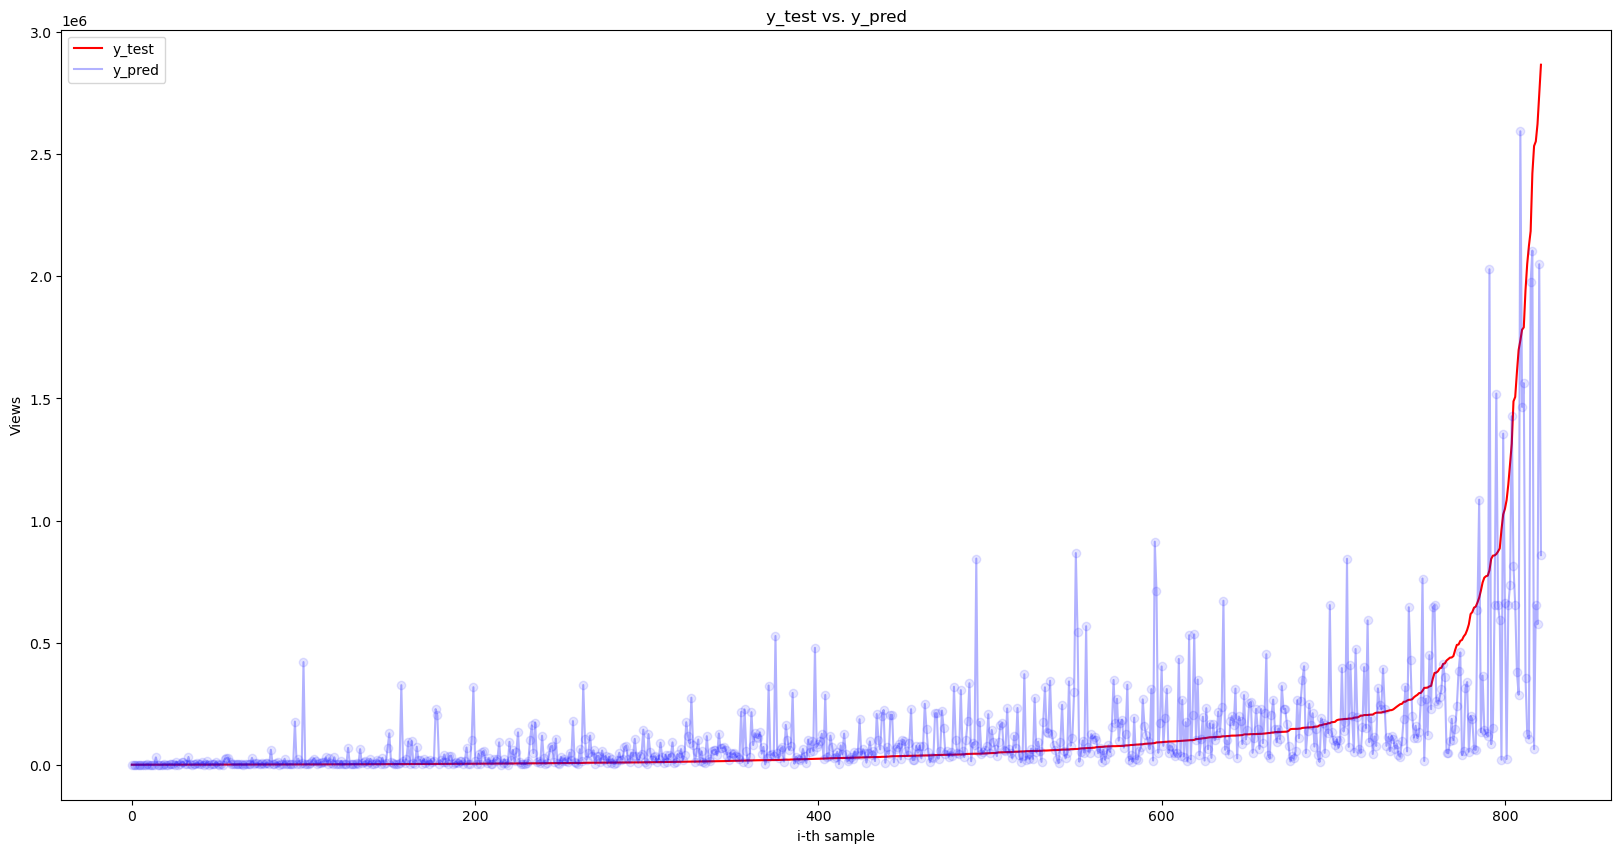

In [25]:
df_pred_sorted = df_pred.sort_values('y_test')

fig, ax = plt.subplots(figsize = (20, 10))
x = np.arange(0, len(y_test))

ax.plot(x, df_pred_sorted['y_test'], "r", label = 'y_test')
ax.plot(x, df_pred_sorted['y_pred'], "b", alpha = 0.3, label = 'y_pred')
ax.plot(x, df_pred_sorted['y_pred'], "bo", alpha = 0.1)
ax.set_xlabel('i-th sample')
ax.set_ylabel('Views')
ax.set_title('y_test vs. y_pred')
ax.legend();

# Results analysis

The graph shows that the model's predictions are not very accurate overall. There are some points that are very close to the actual values, but there are also many points that are very far away. This suggests that the model is not able to generalize well to new data.

The model's accuracy also appears to decline as the sample index increases. This suggests that the model may be overfitting to the earlier samples in the dataset.

# Saving models for deployment

In [26]:
dump(model, '../models/model.joblib')
dump(mlb, '../deploy/materials/mlb.joblib')

['../deploy/materials/mlb.joblib']

# Conclusion

While video duration and tags provide significant insights into potential viewership, achieving truly accurate forecasts necessitates incorporating additional factors. Expanding the feature set with richer data points like sentiment analysis of viewer comments, or historical performance of similar videos could unlock a deeper understanding of audience engagement and lead to significantly more refined predictions.